C:\Users\jrm22n\AppData\Local\Temp\ipykernel_21760\1664136974.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Successfully generated all plots.


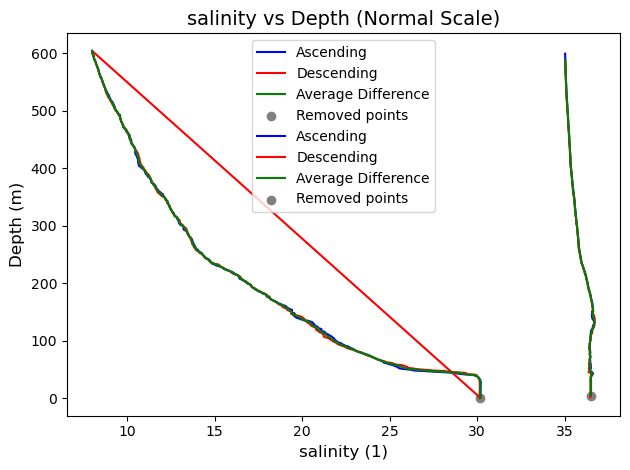

In [2]:
"""
This oceanographic dataset, stored in multiple netCDF files, is from profiling floats tracking ocean properties. Each file contains:

- 'depth': Ocean depth at each measurement.
- 'salinity': Seawater salinity in practical salinity units (PSU).
- 'temperature': Seawater temperature in degrees Celsius.
- 'density': Seawater density, derived from temperature, salinity, and pressure.
- 'lat' and 'lon': Float's geographical coordinates.
- 'time': Measurement timestamp.

The data, unsorted by depth or time due to the float's movement, is grouped by file in an HDF5 format.
"""

# TO-DO:
# Contextualize navigation and profiles vs SSH fields, T-S diagrams
# Find Posseidon profiles (Meunier 2022)
# Calculate steric height of profiles
# Choose which cleaning method is best (data is not clean as is)

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def load_data(file_path):
    try:
        data = xr.open_dataset(file_path)
    except Exception as e:
        print(f"Error occurred while loading the data: {e}")
        return None
    return data

def clean_data(data, variables):
    try:
        data_clean = data.dropna(dim='time', subset=variables, how='all')
    except Exception as e:
        print(f"Error occurred while cleaning the data: {e}")
        return None
    return data_clean

def average_difference(series1, series2, var):
    try:
        depth_values = np.linspace(min(series1['depth']), max(series1['depth']), num=1000)
        interp_func1 = interp1d(series1['depth'], series1[var], bounds_error=False)
        interp_func2 = interp1d(series2['depth'], series2[var], bounds_error=False)
        interp_series1 = pd.Series(interp_func1(depth_values), index=depth_values)
        interp_series2 = pd.Series(interp_func2(depth_values), index=depth_values)
        avg_diff = (interp_series1 + interp_series2) / 2
    except Exception as e:
        print(f"Error occurred while computing average difference: {e}")
        return None
    return avg_diff

def plot_data(df, df_ascending, df_descending, avg_diff, var, units, scale):
    try:
        if scale == "log":
            plt.semilogx(df_ascending[var], df_ascending['depth'], color='blue', label='Ascending')
            plt.semilogx(df_descending[var], df_descending['depth'], color='red', label='Descending')
            plt.semilogx(avg_diff, avg_diff.index, color='green', label='Average Difference')
        elif scale == "loglog":
            plt.loglog(df_ascending[var], df_ascending['depth'], color='blue', label='Ascending')
            plt.loglog(df_descending[var], df_descending['depth'], color='red', label='Descending')
            plt.loglog(avg_diff, avg_diff.index, color='green', label='Average Difference')
        else:
            plt.plot(df_ascending[var], df_ascending['depth'], color='blue', label='Ascending')
            plt.plot(df_descending[var], df_descending['depth'], color='red', label='Descending')
            plt.plot(avg_diff, avg_diff.index, color='green', label='Average Difference')
        removed_points = df.loc[~df.index.isin(df_ascending.index) & ~df.index.isin(df_descending.index)]
        plt.scatter(removed_points[var], removed_points['depth'], color='gray', label='Removed points')
        plt.gca().invert_yaxis()
        plt.title(f'{var} vs Depth ({scale.capitalize()} Scale)', fontsize=14)
        plt.xlabel(f'{var} ({units[var]})', fontsize=12)
        plt.ylabel('Depth (m)', fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'C:/OneDrive/OneDrive - Florida State University/FSU/2023-Summer/TS_fields/Data/LCE_Poseidon/{var}_vs_Depth_cleaned_{scale.capitalize()}.png')
        # plt.close()
    except Exception as e:
        print(f"Error occurred while plotting the data: {e}")


# main

file_path = "C:/OneDrive/OneDrive - Florida State University/FSU/2023-Summer/TS_fields/Data/LCE_Poseidon/pgmog_trajectory6230006.nc"
core_variables = ['temperature', 'salinity']
scales = ["normal"]
# scales = ["normal", "log", "loglog"]

# Load and clean the data
data = load_data(file_path)
if data is None:
    return
units = {var: data[var].units for var in core_variables}
data_clean = clean_data(data, core_variables)
if data_clean is None:
    return

# Prepare the depth data
depth_df = data_clean['depth'].to_dataframe().dropna().reset_index()

# Create the directory for saving plots if it doesn't exist
os.makedirs('C:/OneDrive/OneDrive - Florida State University/FSU/2023-Summer/TS_fields/Data/LCE_Poseidon/final_plots', exist_ok=True)

# Iterate over each core variable and create updated plots with cleaned data
for var in core_variables:
    df_var = data_clean[var].to_dataframe().dropna().reset_index()
    df = pd.merge(df_var, depth_df, on='time', how='inner')
    df_diff = df['depth'].diff()
    df_ascending = df[df_diff > 0]
    df_descending = df[df_diff < 0]
    avg_diff = average_difference(df_ascending, df_descending, var)
    if avg_diff is None:
        continue
    for scale in scales:
        plot_data(df, df_ascending, df_descending, avg_diff, var, units, scale)

print("Successfully generated all plots.")
